In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install -r requirements.txt

In [3]:
# Imports
import string
import re
import random
import csv

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchtext
from torchtext.legacy import data
from torchtext.data.metrics import bleu_score
import pandas as pd
import time
import math
import numpy as np

# Plotting
# for colab
%matplotlib inline 
# for local notebook
# %matplotlib notebook 
import matplotlib.pyplot as plt

from dataset import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [5]:
def sentence_to_index(sentence, stoi) :
    return [stoi.get(ch) if ch in stoi else stoi['<UNK>'] for ch in sentence]

def index_to_sentence(indices, itos) :
    return [itos[id] for id in indices]    

In [6]:
class TwitterDataset(Dataset):
    def __init__(self, df: pd.DataFrame, vocab: torchtext.vocab.Vocab) -> None:
        super().__init__()
        self.df = df
        self.vocab = vocab
        self.vocab_stoi = vocab.get_stoi()
        self.vocab_itos = vocab.get_itos()

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, index: int) -> torch.Tensor:
        sample = self.df.iloc[index]
        tweet = sample['text']
        tweet_ch = ['<BOS>'] + tweet.strip().split() + ['<EOS>']
        tweet_indices = sentence_to_index(tweet_ch, self.vocab_stoi)
        tweet_tensor = torch.tensor(tweet_indices, dtype=torch.long).unsqueeze(0)

        return tweet_tensor

In [7]:
class TextGenerator(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers=1, use_embeds=False):
        super(TextGenerator, self).__init__()
        # self.use_embeds = use_embeds
        self.num_layers = n_layers
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

        self.encoder = nn.Embedding(self.vocab_size, self.hidden_size)
        self.rnn = nn.GRU(
            self.hidden_size,
            self.hidden_size,
            self.num_layers,
            batch_first=True
        )
        self.decoder = nn.Linear(self.hidden_size, self.vocab_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input)              # encode input using embedding layer
        output, hidden = self.rnn(input, hidden) # get the next output and hidden state
        output = self.decoder(output)            # predict distribution over next tokens
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)

In [8]:
def sample_sequence(model, vocab, start_sequence=["<BOS>"], max_len=100, temperature=0.8):
    generated_sequence = ""
    vocab_stoi = vocab.get_stoi()
    vocab_itos = vocab.get_itos()
    inputs = torch.tensor(sentence_to_index(start_sequence, vocab_stoi), dtype=torch.long, device=device)
    hidden = model.init_hidden(1)
    for p in range(max_len):
        output, hidden = model(inputs.unsqueeze(0), hidden)
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = int(torch.multinomial(output_dist, 1)[0])
        # Add predicted character to string and use as next input
        predicted_char = vocab_itos[top_i] # if top_i in range(len(vocab_itos)) else "UNK"
        
        if predicted_char == "<EOS>":
            break
        generated_sequence += predicted_char + " "      
        inputs = torch.tensor([top_i], dtype=torch.long, device=device)
    return generated_sequence

In [9]:
df = load_dataset('elonmusk')
tweets = df['text'].apply(lambda x: x.strip().split()).tolist()
special_tokens = ['<BOS>', '<EOS>', '<UNK>']
vocab = torchtext.vocab.build_vocab_from_iterator(tweets,
                                                  min_freq=2,
                                                  specials=special_tokens)
vocab_stoi = vocab.get_stoi()
vocab_itos = vocab.get_itos()
vocab_size = len(vocab)
dataset = TwitterDataset(df, vocab)

/home/cvxluo/Documents/Projects/Alive/nlp-4650-project/dataset.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[filter]


In [10]:
example = dataset[5].squeeze()
print(index_to_sentence(example, vocab_itos))

['<BOS>', 'Am', 'reading', 'a', 'great', 'biography', 'of', '<UNK>', '<UNK>', 'by', '<UNK>', 'Highly', '<UNK>', '<EOS>']


In [11]:
def train(model, iterator, vocab, batch_size=1, num_epochs=1, lr=0.001, print_every=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    it = 0
    model.zero_grad()

    candidates = []
    references = []
    
    losses = []
    bleu_scores = []
    perplexities = []

    for e in range(num_epochs):
        # get training set
        avg_loss = 0
        avg_perplexity = 0
        hidden = model.init_hidden(batch_size)

        for tweet in iterator:
            tweet = tweet.view(1, -1).to(device)
            target = tweet[:, 1:]
            input = tweet[:, :-1]

            # cleanup
            optimizer.zero_grad()
            # forward pass
            output, hidden = model(input, hidden)
            loss = criterion(output.reshape(-1, vocab_size), target.reshape(-1))
            hidden = hidden.detach()

            # backward pass
            loss.backward()
            optimizer.step()

            avg_loss += loss
            avg_perplexity += math.exp(loss)
            it += 1 # increment iteration count
            if it % print_every == 0:
                '''
                # BLEU score calculation
                candidates = [sample_sequence(model, vocab, temperature=0.6).split()] # for i in range(3)]
                reference_corp = list(map(lambda ids : index_to_sentence(ids.squeeze(), vocab_itos), iterator))
                references = [reference_corp] # for i in range(3)]
                bleu = bleu_score(candidate_corpus=candidates, references_corpus=references, max_n=4)
                '''
                bleu = 0

                print("[Epoch %d Iter %d] Loss %f, BLEU %f" % (e+1, it+1, float(avg_loss/print_every), bleu))
                print("    " + sample_sequence(model, vocab))
                losses.append(avg_loss.item())
                bleu_scores.append(bleu)
                perplexities.append(avg_perplexity)
                avg_perplexity = 0
                avg_loss = 0


    return losses, bleu_scores, perplexities

In [12]:
hidden_size = 256
n_layers = 1
batch_size = 1
lr = 0.001
num_epochs = 10

data_iterator = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = TextGenerator(vocab_size, hidden_size, n_layers=n_layers).to(device)

In [13]:
avg_losses, bleu_scores, perplexities = train(model, data_iterator, vocab, batch_size=batch_size, num_epochs=num_epochs, lr=lr, print_every=500)

[Epoch 1 Iter 501] Loss 6.400661, BLEU 0.000000
    Tesla C Ascent a you. mins chart today's will grid comic … 
[Epoch 1 Iter 1001] Loss 6.121593, BLEU 0.000000
    impossible 
[Epoch 1 Iter 1501] Loss 5.807977, BLEU 0.000000
    <UNK> 
[Epoch 1 Iter 2001] Loss 5.766633, BLEU 0.000000
    News 
[Epoch 1 Iter 2501] Loss 5.636831, BLEU 0.000000
    Doge 
[Epoch 1 Iter 3001] Loss 5.603042, BLEU 0.000000
    <UNK> 
[Epoch 2 Iter 3501] Loss 3.332049, BLEU 0.000000
    pass Mars 
[Epoch 2 Iter 4001] Loss 4.692747, BLEU 0.000000
    PDT can be webcast live take closer <UNK> 
[Epoch 2 Iter 4501] Loss 4.600001, BLEU 0.000000
    <UNK> <UNK> in 2 
[Epoch 2 Iter 5001] Loss 4.619225, BLEU 0.000000
    My favorite Full Self-Driving with a C19 
[Epoch 2 Iter 5501] Loss 4.604082, BLEU 0.000000
    <UNK> <UNK> 
[Epoch 2 Iter 6001] Loss 4.486149, BLEU 0.000000
    . Tesla Model X video 
[Epoch 3 Iter 6501] Loss 1.471416, BLEU 0.000000
    The <UNK> 
[Epoch 3 Iter 7001] Loss 3.441911, BLEU 0.000000
    

In [14]:
print(sample_sequence(model, vocab, temperature=0.6))

<UNK> 


In [18]:
start = input()
print(start + " " + sample_sequence(model, vocab, start_sequence=start.split(), temperature=0.6))

Space Station planned for 1 


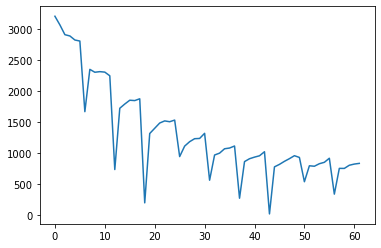

In [20]:
plt.plot(avg_losses)

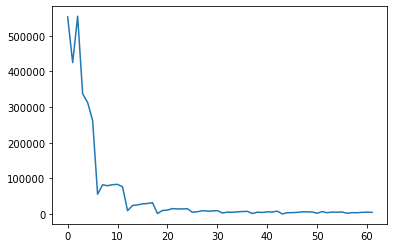

In [21]:
plt.plot(perplexities)